In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, confusion_matrix 

### Análise exploratória

In [17]:
pd.set_option('display.max_columns', None)

# Importando dados de treino e teste
train = pd.read_csv("dados/train.csv")
valid = pd.read_csv("dados/test.csv")
print("Train " + str(train.shape))
print("Test " + str(valid.shape))

Train (70000, 509)
Test (30000, 508)


In [3]:
train.head(15)

,id,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_191,feature_192,feature_193,feature_194,feature_195,feature_196,feature_197,feature_198,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature

In [4]:
# Verificando feature target
train.target.value_counts()

0    49127
1    20873
Name: target, dtype: int64

#### Verificando valores null

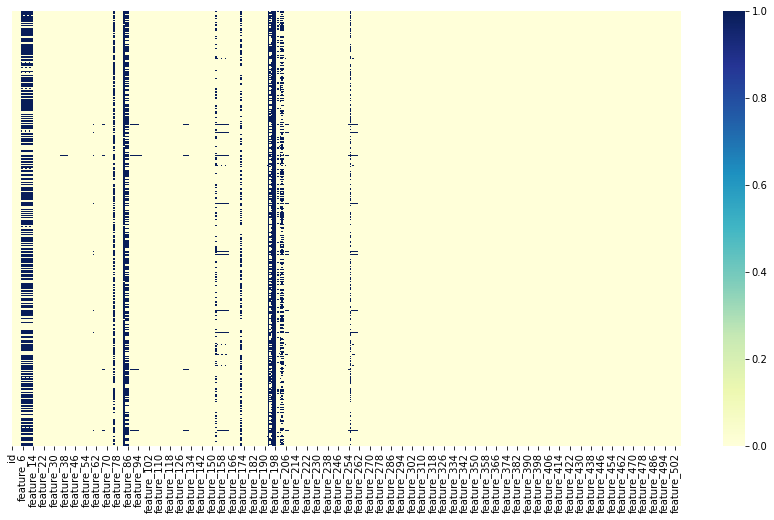

In [5]:
# Verificando valores faltantes
plt.figure(figsize=(15, 8))
sb.heatmap(train.isnull(), cmap="YlGnBu", yticklabels=False)
plt.show()

In [6]:
# Números de valores nulos por feature
train.isnull().sum().sort_values(ascending=False).to_frame().T

,feature_193,feature_196,feature_197,feature_198,feature_83,feature_76,feature_75,feature_195,feature_11,feature_5,feature_8,feature_12,feature_9,feature_6,feature_10,feature_13,feature_7,feature_86,feature_85,feature_84,feature_203,feature_172,feature_255,feature_202,feature_194,feature_204,feature_153,feature_200,feature_257,feature_206,feature_154,feature_157,feature_160,feature_258,feature_155,feature_158,feature_161,feature_207,feature_260,feature_156,feature_159,feature_256,feature_259,feature_60,feature_162,feature_208,feature_192,feature_94,feature_128,feature_67,feature_129,feature_254,feature_88,feature_68,feature_90,feature_92,feature_91,feature_130,feature_131,feature_89,feature_132,feature_93,feature_81,feature_191,feature_201,feature_95,feature_37,feature_39,feature_35,feature_36,feature_38,feature_40,feature_96,feature_361,feature_359,feature_358,feature_357,feature_356,feature_355,feature_360,feature_362,feature_367,feature_363,feature_375,feature_384,feature_383,feature_382,feature_381,feature_380,feature_379,feature_378,feature_377,feature_376,feature_374,feature_364,feature_373,feature_372,feature_371,feature_370,feature_369,feature_368,feature_353,feature_366,feature_365,feature_354,id,feature_352,feature_351,feature_319,feature_318,feature_317,feature_316,feature_315,feature_314,feature_313,feature_312,feature_311,feature_310,feature_309,feature_308,feature_307,feature_306,feature_305,feature_304,feature_303,feature_302,feature_301,feature_300,feature_299,feature_298,feature_297,feature_296,feature_295,feature_294,feature_293,feature_292,feature_291,feature_320,feature_321,feature_322,feature_338,feature_350,feature_349,feature_348,feature_347,feature_346,feature_386,feature_345,feature_344,feature_343,feature_342,feature_341,feature_340,feature_339,feature_337,feature_323,feature_336,feature_335,feature_334,feature_333,feature_332,feature_331,feature_330,feature_329,feature_328,feature_327,feature_326,feature_325,feature_324,feature_385,feature_401,feature_387,feature_388,feature_475,feature_474,feature_473,feature_472,feature_471,feature_470,feature_469,feature_468,feature_467,feature_466,feature_465,feature_464,feature_463,feature_462,feature_461,feature_460,feature_459,feature_458,feature_457,feature_456,feature_455,feature_454,feature_453,feature_452,feature_451,feature_450,feature_449,feature_476,feature_477,feature_478,feature_493,feature_505,feature_504,feature_503,feature_502,feature_501,feature_500,feature_499,feature_498,feature_497,feature_496,feature_495,feature_494,feature_492,feature_479,feature_491,feature_490,feature_489,feature_488,feature_487,feature_486,feature_485,feature_484,feature_483,feature_482,feature_481,feature_480,feature_448,feature_447,feature_446,feature_402,feature_414,feature_413,feature_412,feature_411,feature_410,feature_409,feature_408,feature_407,feature_406,feature_405,feature_404,feature_403,feature_289,feature_416,feature_400,feature_399,feature_398,feature_397,feature_396,feature_395,feature_394,feature_393,feature_392,feature_391,feature_390,feature_389,feature_415,feature_417,feature_445,feature_432,feature_444,feature_443,feature_442,feature_441,feature_440,feature_439,feature_438,feature_437,feature_436,feature_435,feature_434,feature_433,feature_431,feature_418,feature_430,feature_429,feature_428,feature_427,feature_426,feature_425,feature_424,feature_423,feature_422,feature_421,feature_420,feature_419,feature_290,feature_252,feature_288,feature_100,feature_111,feature_110,feature_109,feature_108,feature_107,feature_106,feature_105,feature_104,feature_103,feature_102,feature_101,feature_99,feature_145,feature_98,feature_97,feature_87,feature_82,feature_80,feature_79,feature_78,feature_77,feature_74,feature_73,feature_72,feature_112,feature_113,feature_114,feature_115,feature_143,feature_142,feature_141,feature_140,feature_139,feature_138,feature_137,feature_136,feature_135,feature_134,feature_133,feature_127,feature_126,feature_125,feature_124,feature_123,fea

In [7]:
# Percentual de nan por feature
def get_missings(df):
    labels, values = list(), list()
    if df.isna().sum().sum() > 0:
        for column in df.columns:
            labels.append(column)
            values.append((df[column].isnull().sum() / len(df[column])) * 100)
        missings = pd.DataFrame({"feature": labels, "nan_percent": values}).sort_values(by="nan_percent", ascending=False)
        return missings
    else:
        return False

In [8]:
nan_df = get_missings(train)
nan_df.head(10)

,feature,nan_percent
195,feature_193,100.000000
198,feature_196,100.000000
199,feature_197,100.000000
200,feature_198,100.000000
85,feature_83,98.320000
78,feature_76,70.297143
77,feature_75,70.297143
197,feature_195,63.890000
13,feature_11,63.680000
7,feature_5,63.680000


In [9]:
# Features do tipo object
train.select_dtypes("object")

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_41,feature_42,feature_54,feature_55,feature_58,feature_97,feature_133,feature_134,feature_135,feature_152,feature_163,feature_164,feature_165,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_191,feature_192,feature_194,feature_195,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204,feature_205,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_336,feature_337,feature_338,feature_371
0,C0,C0,C1,C5,C11,C0,C60,C17795,C413,C3620,C0,C0,C0,C19,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C0,C4,C41,C16133,C2,C16,C0,C1,C1,C2,C1483,C6,C0,C0,C20,C0,11/10/2017,11/10/2017,09/11/2017,NaN,11/10/2017,NaN,11/10/2017,NaN,NaN,NaN,C5,C0,C1,C1,C1,C0,C2,C140,C91,C0,C1,C1,C0,C0,C66,C63,C25,C10,C2,C1,C0,C0,C105,C86,C30,C13,C2,C1,C0,C2,C166,C130,C46,C22,C10,C7,C6,C0,C0,C0,C0
1,C0,C0,C3,C5,C1,C2,C50,C14050,C413,C2819,C0,C0,C0,C23,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C0,C7,C41,C21195,C2,C16,C0,C3,C1,C11,C1483,C8,C0,C0,C21,C0,25/03/2015,25/03/2015,NaN,NaN,02/04/2017,25/03/2015,25/03/2015,NaN,NaN,25/03/2015,C9,C0,C2,C2,C1,C14,C3,C193,C66,C0,C1,C1,C0,C0,C80,C74,C29,C13,C5,C2,C1,C0,C128,C104,C36,C18,C6,C3,C2,C0,C130,C105,C36,C18,C6,C3,C2,C0,C0,C0,C0
2,C0,C0,C3,C5,C2,C1,C76,C23471,C413,C4794,C0,C0,C0,C22,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C0,C7,C41,C11390,C2,C16,C0,C3,C1,C11,C1483,C4,C0,C0,C11,C0,27/01/2015,27/01/2015,13/05/2017,NaN,24/03/2016,27/01/2015,27/01/2015,NaN,NaN,27/01/2015,C9,C0,C2,C2,C1,C14,C3,C175,C66,C0,C1,C1,C0,C0,C80,C74,C29,C13,C5,C2,C1,C0,C128,C104,C36,C18,C6,C3,C2,C0,C130,C105,C36,C18,C6,C3,C2,C0,C0,C0,C0
3,C0,C0,C1,C5,C1,C0,C58,C16929,C413,C3344,C0,C0,C0,C2,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C0,C7,C41,C22367,C2,C16,C0,C3,C1,C1,C1483,C2,C0,C0,C5,C0,05/02/2014,01/04/2014,NaN,19/03/2014,01/04/2014,01/04/2014,01/04/2014,31/03/2014,31/03/2014,05/02/2014,C0,C0,C2,C2,C1,C0,C3,C193,C13,C0,C1,C1,C0,C0,C78,C73,C28,C12,C3,C1,C0,C0,C103,C84,C28,C13,C2,C1,C0,C0,C104,C83,C28,C13,C2,C1,C0,C0,C0,C0,C0
4,C0,C0,C3,C3,C11,C2,C48,C13941,C413,C2753,C0,C0,C0,C3,C1,C1,C1,C1,C1,C1,C1,C0,C0,C0,C413,C0,C5,C1,C1652,C2,C16,C0,C0,C1,C11,C1483,C12,C0,C0,C11,C0,20/07/2009,10/09/2013,14/02/2017,NaN,10/09/2013,24/01/2016,10/09/2013,24/01/2016,10/09/2013,23/03/2011,C2,C0,C1,C1,C1,C0,C2,C60,C31,C0,C1,C1,C0,C0,C64,C61,C23,C10,C2,C1,C0,C0,C86,C69,C24,C11,C2,C1,C0,C0,C114,C93,C24,C11,C2,C1,C0,C0,C0,C0,C1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,C0,C0,C3,C1,C11,C0,C87,C26862,C413,C5520,C0,C0,C0,C14,C1,C0,C1,C0,C0,C0,C0,C0,C0,C0,C413,C0,C7,C41,C6619,C2,C16,C1,C2,C1,C11,C1483,C12,C0,C0,C11,C0,27/09/2010,01/02/2014,20/01/2014,29/01/2014,01/02/2014,14/02/2014,01/02/2014,06/07/2017,31/01/2014,27/10/2011,C3,C0,C2,C2,C1,C0,C3,C81,C13,C0,C1,C1,C0,C0,C78,C73,C28,C12,C3,C1,C0,C0,C113,C94,C24,C11,C2,C1,C0,C0,C107,C86,C31,C13,C2,C1,C0,C0,C0,C0,C1
69996,C0,C0,C5,C5,C2,C2,C13,C3347,C413,C593,C0,C0,C0,C17,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,C413,C0,C4,C41,C14535,C2,C16,C0,C3,C2,C2,C1483,C11,C0,C0,C8,C0,19/09/2016,19/09/2016,27/10/2016,NaN,19/09/2016,19/09/2016,19/09/2016,NaN,NaN,NaN,C5,C0,C1,C1,C1,C0,C2,C

### Pré-processamento dos dados

#### Drop features
Neste primeiro momento vamos excluir às features com mais de 20% de valores ausentes, features de data, pois inicialmente para este caso acredito que não teremos diferenças, e também vamos dropar às fetures que tenham apenas um único valor.

In [18]:
# Drop features com mias de 20% de valores faltantes
train = train.drop([col for col in nan_df[nan_df.nan_percent > 20].feature], axis=1)
valid = valid.drop([col for col in nan_df[nan_df.nan_percent > 20].feature], axis=1)

# Drop features de data
train = train.drop(["feature_191", "feature_192", "feature_199", "feature_200", "feature_201"], axis=1)
valid = valid.drop(["feature_191", "feature_192", "feature_199", "feature_200", "feature_201"], axis=1)

# Drop features que contenham valores únicos
drop_list = train.select_dtypes(["int", "float64", "object"]).nunique().sort_values().to_frame().T

train = train.drop([col for col in drop_list.columns if drop_list[col].min() < 2], axis=1)
valid = valid.drop([col for col in drop_list.columns if drop_list[col].min() < 2], axis=1)

train.shape

(70000, 418)

#### Valores null

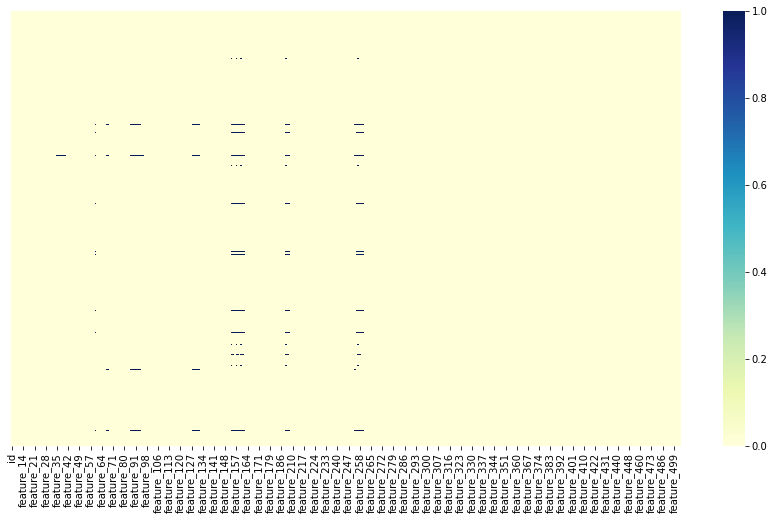

In [14]:
# Verificando valores faltantesapós exclusão das features
plt.figure(figsize=(15, 8))
sb.heatmap(train.isnull(), cmap="YlGnBu", yticklabels=False)
plt.show()

In [19]:
# Sudstituindo valores nulos
train.fillna(1, inplace=True)
valid.fillna(1, inplace=True)

#for col in train.columns:
#    train[col].fillna(train[col].median(), inplace=True)

In [20]:
# Tranformando as features odjects para númericas
for column_name in train.columns:
    if train[column_name].dtype == object:
        train[column_name] = train[column_name].apply(lambda x: str(x).replace(str("C"), "")).astype("float")
        valid[column_name] = valid[column_name].apply(lambda x: str(x).replace(str("C"), "")).astype("float")
    else:
        pass

#### Split

Realizando separação de nosso target e das features, e split entre dados de treino e teste. O conjunto de teste fornecido pelo Kaggle usaremos como validação.

In [21]:
# Separando dados de treino da classe(target)
classe = train.target
train = train.drop(["target","id"], axis=1)

In [22]:
# Split dos dados de treino e teste, para um teste mais consistente temos o conjunto de dados(test)
X_train, X_test, y_train, y_test = train_test_split(train, classe, test_size=0.3, shuffle=True, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((49000, 416), (49000,), (21000, 416), (21000,))

#### Scaling

In [23]:
min_max = MinMaxScaler()
for col in X_train.columns:
    X_train[col] = min_max.fit_transform(X_train[[col]])
    X_test[col] = min_max.fit_transform(X_test[[col]])

In [25]:
X_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_150,feature_151,feature_152,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_189,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_250,feature_251,feature_253,feature_254,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature_341,feature_342,feature_343,feature_344,feature_345,feature_346,feature_347,feature_348,feature_349,feature_350,feature_351,feature_352,feature_353,feature_354,feature_355,feature_356,feature_359,feature_360,feature_361,feature_362,feature_363,feature_364,feature_365,feature_366,feature_367,feature_368,feature_369,feature_370,feature_371,feature_372,feature_373,feature_374,feature_376,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383,feature_384,feature_386,feature_387,feature_388,feature_390,feature_

#### Feature Selection
Utilizando o [**SelectKBest**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) do **scikit-learn** vamos selecionar k melhores features baseda em função(f), que em nosso caso para um classo de classificação vamos utilizar a f_classif (ANOVA).

ANOVA é um método estatístico para verificar se existe diferenças significativas entre as médias de grupos de dados, sendo possível inferir se as variáveis são dependentes uma sobre a outra.

Então, quanto maior o valor de F maior é a evidência de que as variáveis são diferentes entre si e que exercem influência uma sobre a outra.

In [26]:
selector = SelectKBest(score_func=f_classif, k=300)
selector_a = selector.fit(X_train, y_train)
selector_b = selector.transform(X_train)

In [27]:
sel_best = pd.DataFrame(
    {
        "feature": selector.feature_names_in_, 
        "f-score": selector.scores_, 
        "p-value": selector.pvalues_
    }, 
    columns=["feature", "f-score", "p-value"]
).sort_values(by="f-score", ascending=False)

sel_best.head()

,feature,f-score,p-value
264,feature_307,6191.456941,0.000000e+00
254,feature_297,1405.222709,3.071493e-303
69,feature_81,1241.906296,1.107644e-268
167,feature_189,936.140830,1.140347e-203
291,feature_336,852.514245,8.141910e-186


In [28]:
# Novo DataFrame com às melhores features selecionadas pelo SelectKBest
X_train = X_train[list(selector_a.get_feature_names_out())]
X_test = X_test[list(selector_a.get_feature_names_out())]
X_train.head()

,feature_2,feature_3,feature_4,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_48,feature_51,feature_53,feature_58,feature_60,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_72,feature_73,feature_74,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_87,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_99,feature_101,feature_104,feature_108,feature_110,feature_111,feature_114,feature_115,feature_118,feature_122,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_147,feature_148,feature_151,feature_152,feature_154,feature_155,feature_156,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_173,feature_174,feature_177,feature_181,feature_182,feature_185,feature_186,feature_189,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_223,feature_224,feature_226,feature_235,feature_236,feature_239,feature_240,feature_241,feature_243,feature_244,feature_245,feature_246,feature_247,feature_253,feature_254,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_318,feature_319,feature_320,feature_322,feature_328,feature_329,feature_335,feature_336,feature_339,feature_340,feature_341,feature_342,feature_345,feature_346,feature_347,feature_348,feature_351,feature_352,feature_353,feature_354,feature_355,feature_356,feature_365,feature_366,feature_367,feature_368,feature_369,feature_370,feature_371,feature_372,feature_374,feature_376,feature_378,feature_380,feature_381,feature_382,feature_383,feature_384,feature_386,feature_387,feature_388,feature_390,feature_391,feature_392,feature_394,feature_396,feature_398,feature_399,feature_400,feature_402,feature_403,feature_404,feature_406,feature_408,feature_410,feature_414,feature_415,feature_416,feature_418,feature_420,feature_422,feature_424,feature_426,feature_428,feature_429,feature_430,feature_434,feature_435,feature_436,feature_437,feature_438,feature_440,feature_441,feature_442,feature_444,feature_446,feature_448,feature_450,feature_452,feature_454,feature_456,feature_457,feature_458,feature_460,feature_462,feature_464,feature_466,feature_468,feature_470,feature_471,feature_473,feature_475,feature_477,feature_479,feature_481,feature_483,feature_485,feature_486,feature_488,feature_490,feature_492,feature_494,feature_496,feature_497,feature_499,feature_501,feature_503,feature_504,feature_506
59982,0.2,1.0,0.909091,0.000000,0.00000,0.666667,0.650485,0.723629,1.0,0.679643,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.142857,0.009881,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.099617,0.00000,0.0,0.000000,0.00000,0.000012,0.000000,0.000000,0.000000,0.97561,0.0,0.0,0.0,1.0,1.0,0.0,0.428571,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.000000,0.0,0.5,0.0,0.

### Modelo

#### XGBoost

In [29]:
modelo = XGBClassifier(
    n_estimators=1200,
    #max_depth=2,
    learning_rate=0.01,
    #colsample_bynode=0.1472,
    min_child_weight=2, 
    subsample=0.5,
    num_parallel_tree=3,
    random_state=0
)
    
modelo.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="auc")

[0]	validation_0-auc:0.75892
[1]	validation_0-auc:0.76258
[2]	validation_0-auc:0.76362
[3]	validation_0-auc:0.76338
[4]	validation_0-auc:0.76416
[5]	validation_0-auc:0.76439
[6]	validation_0-auc:0.76442
[7]	validation_0-auc:0.76476
[8]	validation_0-auc:0.76486
[9]	validation_0-auc:0.76456
[10]	validation_0-auc:0.76476
[11]	validation_0-auc:0.76480
[12]	validation_0-auc:0.76489
[13]	validation_0-auc:0.76479
[14]	validation_0-auc:0.76475
[15]	validation_0-auc:0.76475
[16]	validation_0-auc:0.76479
[17]	validation_0-auc:0.76468
[18]	validation_0-auc:0.76480
[19]	validation_0-auc:0.76486
[20]	validation_0-auc:0.76513
[21]	validation_0-auc:0.76518
[22]	validation_0-auc:0.76533
[23]	validation_0-auc:0.76531
[24]	validation_0-auc:0.76531
[25]	validation_0-auc:0.76543
[26]	validation_0-auc:0.76549
[27]	validation_0-auc:0.76552
[28]	validation_0-auc:0.76568
[29]	validation_0-auc:0.76579
[30]	validation_0-auc:0.76585
[31]	validation_0-auc:0.76590
[32]	validation_0-auc:0.76595
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=6, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=1200, n_jobs=8,
              num_parallel_tree=3, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
previstos = modelo.predict_proba(X_test)[:,1]

result = roc_auc_score(y_test, previstos)
print("ROC score = {:0.2f}%".format(result * 100))

ROC score = 78.43%


In [31]:
fpr, tpr, thresholds = roc_curve(y_test, previstos)
roc_auc = auc(fpr, tpr)
roc_auc

0.7842543180578474

Text(0.5, 0, 'False Positive Rate')

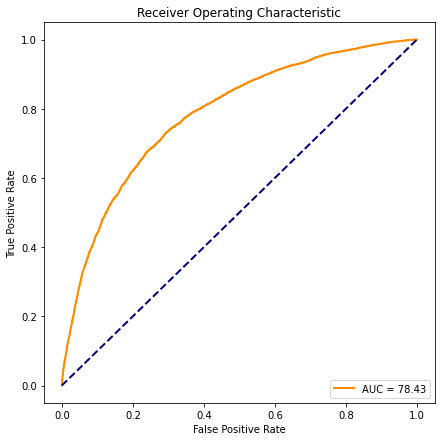

In [32]:
plt.figure(figsize=(7, 7))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr, color="darkorange", lw=2, label="AUC = %0.2f" % (roc_auc*100))
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

#### Tuning - Bayesian Optimization
Otimização Bayesiana com a lib bayes_opt

In [33]:
def xgboost_bayesian_selector(n_estimators, max_depth, learning_rate, colsample_bynode, min_child_weight, subsample):
    modelo = XGBClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        colsample_bynode=colsample_bynode,
        min_child_weight=int(min_child_weight), 
        subsample=subsample,
        random_state=0
    )
    
    modelo.fit(X_train, y_train, eval_metric="auc")

    previstos = modelo.predict_proba(X_test)[:,1]
    result = roc_auc_score(y_test, previstos)

    return result

In [34]:
pbounds = {
    "n_estimators": (500, 2500),
    "max_depth": (1, 10),
    "learning_rate": (0.01, 0.20),
    "colsample_bynode": (0.01, 0.90),
    "min_child_weight": (1, 5),
    "subsample": (0.01, 0.9)
}

optimizer = BayesianOptimization(f=xgboost_bayesian_selector, pbounds=pbounds, verbose=2, random_state=0)
optimizer.maximize(init_points=2, n_iter=15)

print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.7383   |  0.4984   |  0.1459   |  6.425    |  3.18     |  1.347e+0 |  0.5848   |
|  2        |  0.7369   |  0.3995   |  0.1794   |  9.673    |  2.534    |  2.083e+0 |  0.4807   |
|  3        |  0.7662   |  0.1624   |  0.05691  |  6.364    |  3.534    |  1.346e+0 |  0.6315   |
|  4        |  0.7723   |  0.2374   |  0.1108   |  2.202    |  4.928    |  2.178e+0 |  0.2899   |
|  5        |  0.7794   |  0.5492   |  0.01245  |  6.539    |  2.652    |  2.483e+0 |  0.3876   |
|  6        |  0.7826   |  0.1472   |  0.03333  |  2.082    |  4.895    |  1.11e+03 |  0.4651   |
|  7        |  0.767    |  0.1571   |  0.04606  |  5.178    |  4.583    |  1.44e+03 |  0.1798   |
|  8        |  0.7351   |  0.2038   |  0.1554   |  6.117    |  3.558    |  625.4    |  0.2989   |
|  9        |  0.770

#### Cross Validation

In [31]:
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

X = train
y = np.zeros(shape=(train.shape[0], 1))

score_roc_auc = []

for train_index, test_index in skf.split(X, y):
    X_train = train.iloc[train_index] 
    X_test = train.iloc[test_index]

    y_train = classe.iloc[train_index] 
    y_test = classe.iloc[test_index]

    modelo.fit(X_train, y_train, eval_metric="auc")

    previstos = modelo.predict_proba(X_test)[:,1]
    result = roc_auc_score(y_test, previstos)
    
    print("ROC score = {:0.5f}%".format(result))
    score_roc_auc.append(result)

ROC score = 0.78746%
ROC score = 0.78612%
ROC score = 0.78056%
ROC score = 0.78347%
ROC score = 0.78450%


In [35]:
np.mean(score_roc_auc)

0.7844226804710411

### Submission

In [ ]:
submit = pd.DataFrame(valid.id)
mask = train.columns
valid = valid.drop([col for col in valid.columns if not col in mask], axis=1)

In [ ]:
for col in valid.columns:
    valid[col] = min_max.fit_transform(valid[[col]])

In [120]:
submit["target"] = modelo.predict_proba(valid)[:,1]
submit["target"] = submit["target"].apply(lambda x: round(x, 5))
submit.to_csv("submission.csv", index=False)